# Notebook for Model Evaluation

## Create Predictions

In [1]:
from datasets import load_dataset

# Load dataset
ds = load_dataset("imagefolder", data_dir="dataset", split="train")
ds = ds.train_test_split(test_size=0.2, seed=512)
labels = ds['train'].features['label'].names

c:\Users\Dylan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 2527/2527 [00:00<00:00, 54935.06it/s]


In [2]:
# Load model (change this to switch model being evaluated)
model_name = "clip-base"

from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoProcessor, AutoModel
import torch

if model_name == "vit":
    processor = AutoImageProcessor.from_pretrained("vit-base-trash")
    model = AutoModelForImageClassification.from_pretrained("vit-base-trash").to("cuda")
elif model_name == "resnet":
    processor = AutoImageProcessor.from_pretrained("resnet-50-trash")
    model = AutoModelForImageClassification.from_pretrained("resnet-50-trash").to("cuda")
elif model_name == "clip-trash":
    processor = AutoProcessor.from_pretrained("clip-trash-s2")
    model = AutoModel.from_pretrained("clip-trash-s2").to("cuda")
elif model_name == "clip-base":
    processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
    model = AutoModel.from_pretrained("openai/clip-vit-base-patch32").to("cuda")

In [3]:
import numpy as np

# Caption map for CLIP model
caption_map = {
    "cardboard": "a photo of cardboard",
    "glass": "a photo of glass",
    "metal": "a photo of metal",
    "paper": "a photo of paper",
    "plastic": "a photo of plastic",
    "trash": "a photo of trash"
}
captions = [caption_map[label] for label in labels]

# Process images and predict
def predict_images(batch):
    if model_name == "clip-trash" or model_name == "clip-base":
        inputs = processor(text=captions, images=batch['image'], return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(**inputs.to("cuda"))
        batch['pred'] = np.argmax(outputs.logits_per_image.detach().cpu().numpy(), axis=1)
    else:
        inputs = processor(images=batch['image'], return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(**inputs.to("cuda"))
        batch['pred'] = np.argmax(outputs.logits.detach().cpu().numpy(), axis=1)
    return batch

train_preds = ds['train'].map(predict_images, batched=True, batch_size=32).with_format("numpy")
test_preds = ds['test'].map(predict_images, batched=True, batch_size=32).with_format("numpy")

Map: 100%|██████████| 506/506 [00:04<00:00, 106.98 examples/s]


## Evaluate Predictions

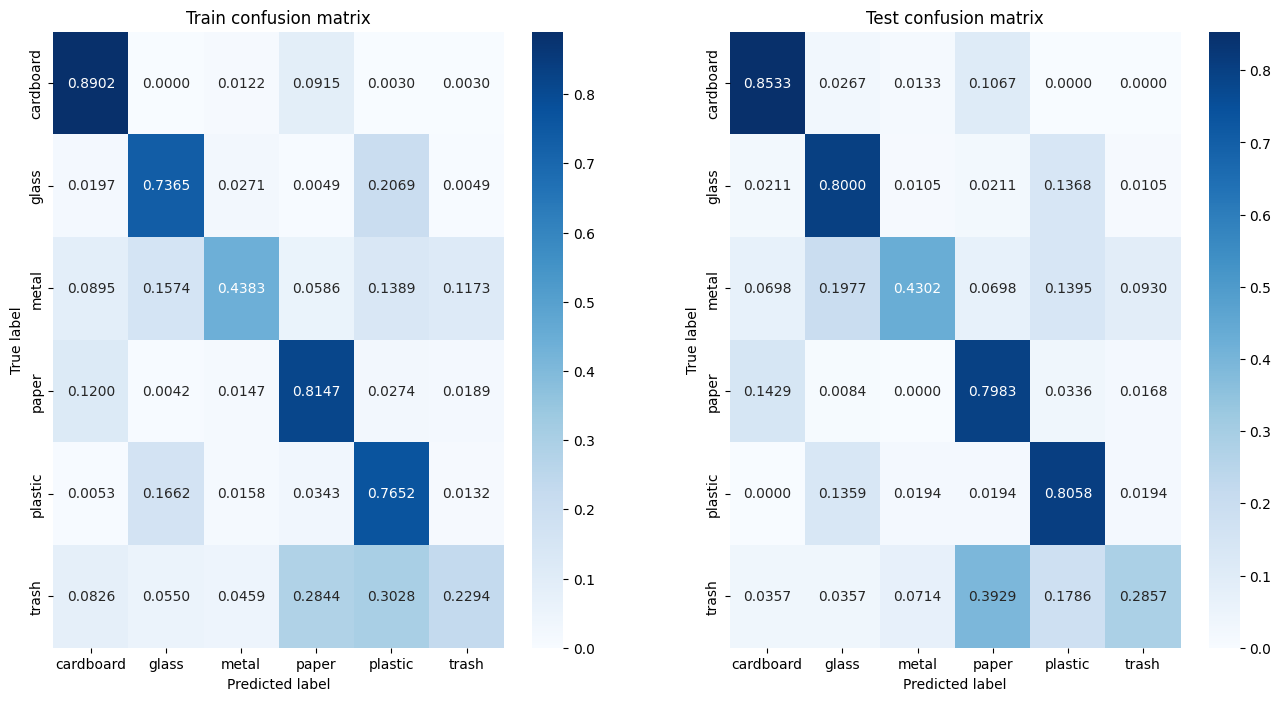

In [4]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train_preds['label'], train_preds['pred'])
test_cm = confusion_matrix(test_preds['label'], test_preds['pred'])
train_cm_percent = train_cm / np.sum(train_cm, axis=1, keepdims=True)
test_cm_percent = test_cm / np.sum(test_cm, axis=1, keepdims=True)

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.heatmap(train_cm_percent, annot=True, xticklabels=labels, yticklabels=labels, ax=ax[0], fmt='.4f', cmap='Blues')
sns.heatmap(test_cm_percent, annot=True, xticklabels=labels, yticklabels=labels, ax=ax[1], fmt='.4f', cmap='Blues')
ax[0].set_title("Train confusion matrix")
ax[1].set_title("Test confusion matrix")
ax[0].set_xlabel("Predicted label")
ax[1].set_xlabel("Predicted label")
ax[0].set_ylabel("True label")
ax[1].set_ylabel("True label")
plt.show()